# Classificazione ECG: punto 2
In questa parte del progetto si è variato il learning rate del SGD e i layer del modello considerato utilizzando il dataset con data augmentation ottenuto dal punto 1. Nel variare il learning rate si è utilizzato comunque un modelllo con meno parametri rispetto a quello del punto precedente (71724 parametri).

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential,utils, regularizers, initializers, optimizers
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout, Softmax
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks
from tensorflow import keras
import tensorflow as tf

Rifacciamo il download dei dati e li reinseriamo nei vettori di train, test e validation, con data augmentation

In [ ]:
meta = pd.read_csv(r'C:\Users\bianc\Desktop\Reti neurali\meta.csv', header = None, error_bad_lines=False)
meta = pd.DataFrame(meta)

In [ ]:
patients=[]
for i in range(294):
    if (i+1)!=124 and (i+1)!=132 and (i+1)!=134 and (i+1)!=161 and (i+1)!=139:
        patients.append(i+1)
patients=np.array(patients)

patient_new = []
for i in patients:
    if i < 10:
        p = 'patient00%i' % i
    elif i < 100 and i > 9:
        p = 'patient0%i' % i
    else:
        p = 'patient%i' % i
        
    for j in range(550):
        if p == meta.iloc[j][0]:
            if meta.iloc[j][13] == 'Myocardial infarction' or meta.iloc[j][13] == 'Healthy control':
                patient_new.append(i)
                break
                
patients = np.array(patient_new)                


In [ ]:
num_battiti = []
X = []
for i in patients:
    if i < 10:
        file = 'ECG_lead2_patient00%i.npy' % i
    elif i < 100 and i > 9:
        file = 'ECG_lead2_patient0%i.npy' % i
    else:
        file = 'ECG_lead2_patient%i.npy' % i
    a = np.load(file, allow_pickle=True)
    c = 0
    for i in a:
        X.append(i)
        c+=1
    num_battiti.append(c)
    
num_battiti = np.array(num_battiti)
X = np.array(X)
print(num_battiti)

In [ ]:
num_battiti_MI = np.zeros(294) # numero di battiti per ogni file dei pazienti con infarto del miocardio
X_MI = [] #ECG corrispondenti
for i in range(1, 550):
    p = int(meta.iloc[i][0].split('t')[2])
    file = 'ECG%i.npy' % i
    try:
        a = np.load(file, allow_pickle=True)
        c = 0
        for i in a:
            X_MI.append(i)
            c+=1
        num_battiti_MI[p-1] += c
    except:
        print('File does not exist')
    
num_battiti_MI = num_battiti_MI.astype(int)
X_MI = np.array(X_MI)
print(num_battiti_MI)
print(num_battiti_MI.size)

In [ ]:
X_total = np.concatenate((X, X_MI))
X_total.shape

In [ ]:
y_label = []
for i in patients:
    if i < 10:
        line = 'patient00%i' % i
    elif i < 100 and i > 9:
        line = 'patient0%i' % i
    else:
        line = 'patient%i' % i
    for i in range(1, 550):
        if meta.iloc[i][0] == line:
            if meta.iloc[i][13] == 'Myocardial infarction':
                if meta.iloc[i][14] == 'anterior':
                    label = 1
                elif meta.iloc[i][14] == 'infero-latera' or meta.iloc[i][14] == 'infero-lateral':
                    label = 2
                elif meta.iloc[i][14] == 'antero-lateral':
                    label = 3
                elif meta.iloc[i][14] == 'inferior':
                    label = 4
                elif meta.iloc[i][14] == 'antero-septal':
                    label = 5
                elif meta.iloc[i][14] == 'infero-posterior-lateral' or meta.iloc[i][14] == 'infero-postero-lateral' or meta.iloc[i][14] == 'infero-poster-lateral':
                    label = 6
                elif meta.iloc[i][14] == 'postero-lateral':
                    label = 7
                elif meta.iloc[i][14] == 'posterior':
                    label = 8
                elif meta.iloc[i][14] == 'lateral':
                    label = 9
                elif meta.iloc[i][14] == 'infero-posterior':
                    label = 10
                elif meta.iloc[i][14] == 'antero-septo-lateral':
                    label = 11
            elif meta.iloc[i][13] == 'Healthy control':
                label = 0
            y_label.append(label)
            break
            
y_label = np.array(y_label)
y_label.size

In [ ]:
y_label_new = []
for i in range(y_label.size):
    for j in range(num_battiti[i]):
        y_label_new.append(y_label[i])
        
y_label = np.array(y_label_new)
y_label.size

In [ ]:
y_label_MI = np.zeros(294) #creazione dei vettori di label
for j in MI_MoreThanOne:
    if j < 10:
        line = 'patient00%i' % j
    elif j < 100 and i > 9:
        line = 'patient0%i' % j
    else:
        line = 'patient%i' % j
    for i in range(1, 550):
        if meta.iloc[i][0] == line:
            if meta.iloc[i][13] == 'Myocardial infarction':
                if meta.iloc[i][14] == 'anterior':
                    label = 1
                elif meta.iloc[i][14] == 'infero-latera' or meta.iloc[i][14] == 'infero-lateral':
                    label = 2
                elif meta.iloc[i][14] == 'antero-lateral':
                    label = 3
                elif meta.iloc[i][14] == 'inferior':
                    label = 4
                elif meta.iloc[i][14] == 'antero-septal':
                    label = 5
                elif meta.iloc[i][14] == 'infero-posterior-lateral' or meta.iloc[i][14] == 'infero-postero-lateral' or meta.iloc[i][14] == 'infero-poster-lateral':
                    label = 6
                elif meta.iloc[i][14] == 'postero-lateral':
                    label = 7
                elif meta.iloc[i][14] == 'posterior':
                    label = 8
                elif meta.iloc[i][14] == 'lateral':
                    label = 9
                elif meta.iloc[i][14] == 'infero-posterior':
                    label = 10
                elif meta.iloc[i][14] == 'antero-septo-lateral':
                    label = 11
            elif meta.iloc[i][13] == 'Healthy control':
                label = 0
            y_label_MI[j-1] += label
            break
            
y_label_MI = y_label_MI.astype(int)
y_label_MI.size

In [ ]:
#togliamo gli zeri
y_label_new = []
num_battiti_new = []
for i in range(y_label_MI.size):
    if y_label_MI[i] != 0:
        y_label_new.append(y_label_MI[i])
        num_battiti_new.append(num_battiti_MI[i])
        
y_label_MI = np.array(y_label_new)
num_battiti_MI = np.array(num_battiti_new)
print(y_label_MI.size)
print(num_battiti_MI.size)

In [ ]:
#creiamo il vettore di label per gli MI
y_label_new = []
for i in range(y_label_MI.size):
    for j in range(num_battiti_MI[i]):
        y_label_new.append(y_label_MI[i])
        
y_label_MI = np.array(y_label_new)
y_label_MI.size

In [ ]:
Y_total = np.concatenate((y_label, y_label_MI))

In [ ]:
#togliamo i battiti sottocampionati
X_total_new = []
Y_total_new = []
for i in range(X_total.shape[0]):
    if X_total[i].size==650:
        X_total_new.append(X_total[i])
        Y_total_new.append(Y_total[i])
X_total = np.array(X_total_new)
Y_total = np.array(Y_total_new)
print(X_total.shape)
print(Y_total.size)

In [ ]:
N = X_total.shape[0]

n = np.arange(N)

import random
cut = int(0.85 * N) #85% del totale
random.shuffle(n)
X_train_index = n[:cut] # first 85% train
X_test_index = n[cut:] # last 15% test

cut1 = int(0.128 * len(X_train_index))
random.shuffle(X_train_index)
X_train_index = X_train_index[cut1:] # last 70% train
X_val_index = X_train_index[:cut1] # first 15% validation

X_test_index = np.array(X_test_index)
X_train_index = np.array(X_train_index)
X_val_index = np.array(X_val_index)

In [ ]:
Xtrain = []
Ytrain = []
Xval = []
Yval = []
Xtest = []
Ytest = []
for i in X_train_index:
    Xtrain.append(X_total[i])
    Ytrain.append(Y_total[i])
for i in X_test_index:
    Xtest.append(X_total[i])
    Ytest.append(Y_total[i])
for i in X_val_index:
    Xval.append(X_total[i])
    Yval.append(Y_total[i])
    
Xtrain = np.array(Xtrain, dtype=object)
Ytrain = np.array(Ytrain, dtype=object)
Xtest = np.array(Xtest, dtype=object)
Ytest = np.array(Ytest, dtype=object)
Xval = np.array(Xval, dtype=object)
Yval = np.array(Yval, dtype=object)

In [ ]:
#Applico una maschera sui vettori Xtrain. Seleziono quelli con un determinato label
df_0  = Xtrain[Ytrain == 0]
df_1  = Xtrain[Ytrain == 1]
df_2  = Xtrain[Ytrain == 2]
df_3  = Xtrain[Ytrain == 3]
df_4  = Xtrain[Ytrain == 4]
df_5  = Xtrain[Ytrain == 5]
df_6  = Xtrain[Ytrain == 6]
df_7  = Xtrain[Ytrain == 7]
df_8  = Xtrain[Ytrain == 8]
df_9  = Xtrain[Ytrain == 9]
df_10 = Xtrain[Ytrain == 10]
df_11 = Xtrain[Ytrain == 11]

In [ ]:
#data augmentation
from sklearn.utils import resample

df_0_upsample = resample(df_0, n_samples = 10000, replace = True, random_state = 123)
df_1_upsample = resample(df_1, n_samples = 10000, replace = True, random_state = 123)
df_2_upsample = resample(df_2, n_samples = 10000, replace = True, random_state = 123)
df_3_upsample = resample(df_3, n_samples = 10000, replace = True, random_state = 123)
df_6_upsample = resample(df_6, n_samples = 10000, replace = True, random_state = 123)
df_7_upsample = resample(df_7, n_samples = 10000, replace = True, random_state = 123)
df_8_upsample = resample(df_8, n_samples = 10000, replace = True, random_state = 123)
df_9_upsample = resample(df_9, n_samples = 10000, replace = True, random_state = 123)
df_10_upsample = resample(df_10, n_samples = 10000, replace = True, random_state = 123)
df_11_upsample = resample(df_11, n_samples = 10000, replace = True, random_state = 123)

In [ ]:
df_4_downsample = resample(df_4, n_samples = 10000, replace = False, random_state = 123)
df_5_downsample = resample(df_5, n_samples = 10000, replace = False, random_state = 123)

In [ ]:
train_df=np.concatenate((df_0_upsample, df_1_upsample, df_2_upsample, df_3_upsample, df_4_downsample, df_5_downsample, df_6_upsample, df_7_upsample, df_8_upsample, df_9_upsample, df_10_upsample, df_11_upsample))
Xtrain = train_df
Ytrain_df=[]
for h in range(12):
    for i in range(10000):
        Ytrain_df.append(h) 
        
Ytrain_df=np.array(Ytrain_df)
Ytrain = Ytrain_df

In [ ]:
print('shape train before: ',Xtrain.shape)
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain[0].size,1)
print('shape train after: ',Xtrain.shape)
print('shape validation before: ',Xval.shape)
Xval = Xval.reshape(Xval.shape[0],Xval[0].size,1)
print('shape validation before: ',Xval.shape)
input_shape = (Xtrain[0].size,1)

batch_size = 64
epochs = 50

In [ ]:
#transform integer label into one-hot encodings
n_classes=12

Ytrain_cat = keras.utils.to_categorical(Ytrain, n_classes)
Yval_cat = keras.utils.to_categorical(Yval, n_classes)
Ytest_cat = keras.utils.to_categorical(Ytest, n_classes)
Xtrain = np.asarray(Xtrain).astype('float32')
Xval = np.asarray(Xval).astype('float32')

In [17]:
def create_model_diminuito(optimizer, activation='relu'):
    model = Sequential()
    model.add(Conv1D(64, 5, strides=1, input_shape = input_shape, activation=activation))
    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, 5, strides=1, activation=activation))
    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(12, activation = activation))
    model.add(Softmax())
    
    print(model.summary())

    model.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizer, metrics = ['accuracy']) 
    
    return model

I learning rate considerati sono: 0.01, 0.001, 0.1, 0.005, 0.05 e 0.008

# SGD Learning rate 0.01

In [46]:
opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
model0 = create_model_diminuito(opt)

fit = model0.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_lr0 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 323, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 323, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 319, 32)           10272     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 159, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5088)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)               

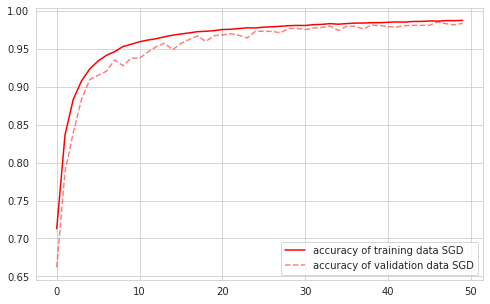

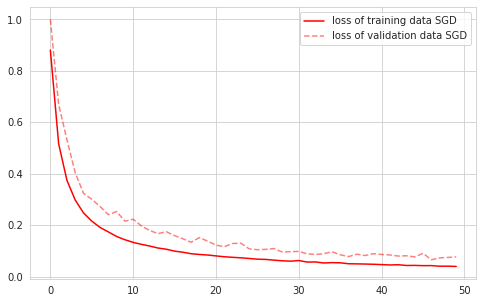

In [47]:
i=0
plt.plot(SGD_lr0[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_lr0[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_lr0[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_lr0[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

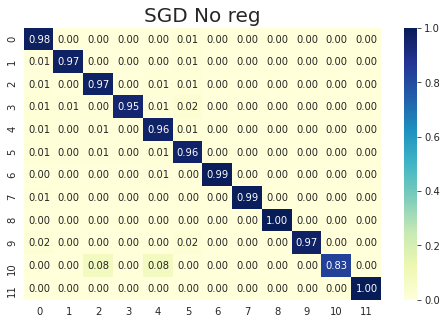

In [49]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model0.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD lr 0.01', fontsize=20)
plt.show()

# SGD Learning rate 0.001

In [62]:
opt = optimizers.SGD(lr = 0.001, momentum = 0.9, nesterov = True, decay = 1e-6)
model1 = create_model_diminuito(opt)

fit = model1.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_lr1 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 323, 64)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 323, 64)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 319, 32)           10272     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 159, 32)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 5088)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 12)               

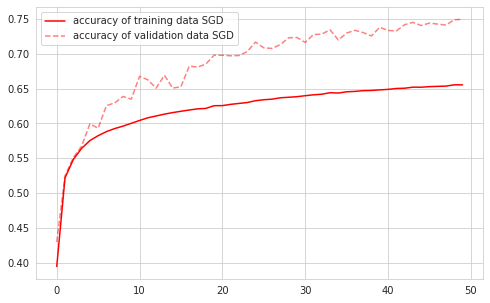

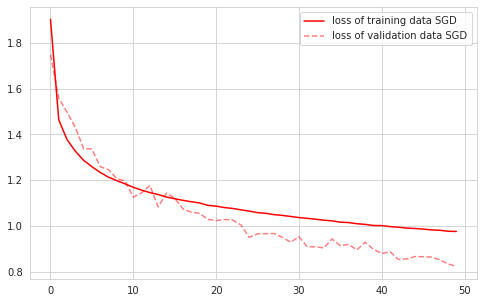

In [63]:
i=0
plt.plot(SGD_lr1[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_lr1[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_lr1[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_lr1[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

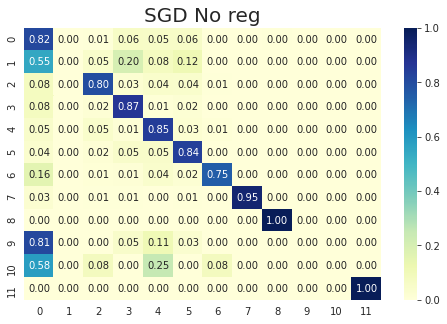

In [64]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model1.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD lr 0.001', fontsize=20)
plt.show()

# SGD Learning rate 0.1

In [53]:
opt = optimizers.SGD(lr = 0.1, momentum = 0.9, nesterov = True, decay = 1e-6)
model2 = create_model_diminuito(opt)

fit = model2.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_lr2 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 323, 64)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 323, 64)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 319, 32)           10272     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 159, 32)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5088)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)               

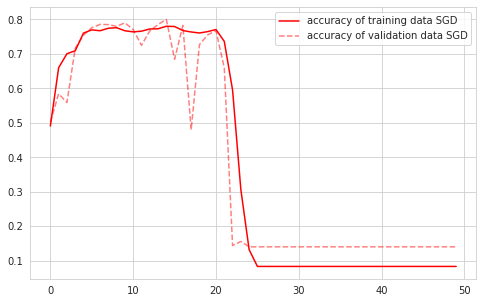

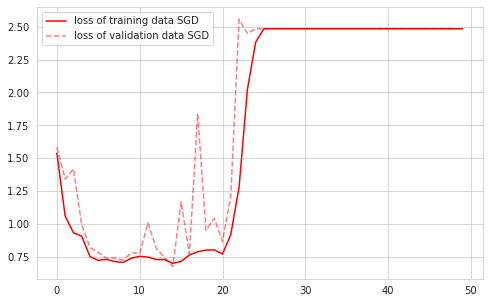

In [54]:
i=0
plt.plot(SGD_lr2[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_lr2[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_lr2[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_lr2[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

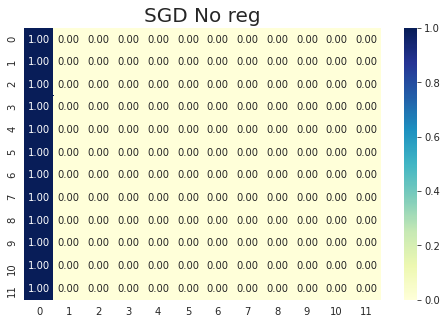

In [55]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model2.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD lr 0.1', fontsize=20)
plt.show()

# SGD Learning rate 0.005

In [56]:
opt = optimizers.SGD(lr = 0.005, momentum = 0.9, nesterov = True, decay = 1e-6)
model3 = create_model_diminuito(opt)

fit = model3.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_lr3 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 323, 64)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 323, 64)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 319, 32)           10272     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 159, 32)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5088)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 12)               

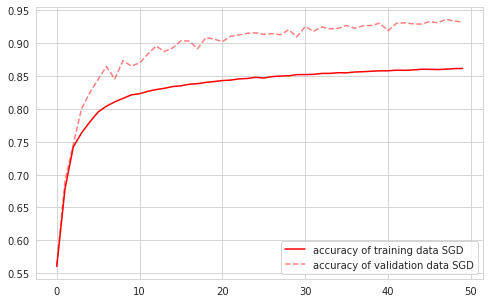

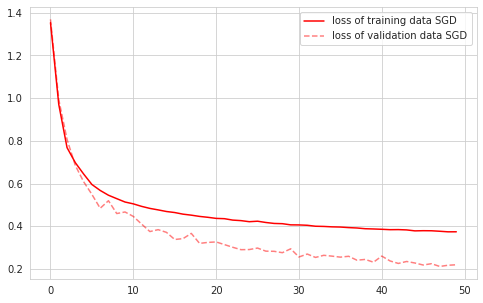

In [57]:
i=0
plt.plot(SGD_lr3[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_lr3[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_lr3[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_lr3[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

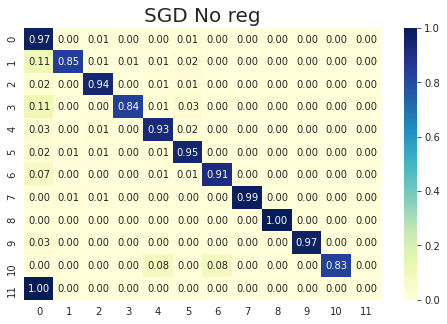

In [58]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model3.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD lr 0.005', fontsize=20)
plt.show()

# SGD Learning rate 0.05

In [65]:
opt = optimizers.SGD(lr = 0.05, momentum = 0.9, nesterov = True, decay = 1e-6)
model4 = create_model_diminuito(opt)

fit = model4.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_lr4 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 323, 64)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 323, 64)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 319, 32)           10272     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 159, 32)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 5088)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 12)               

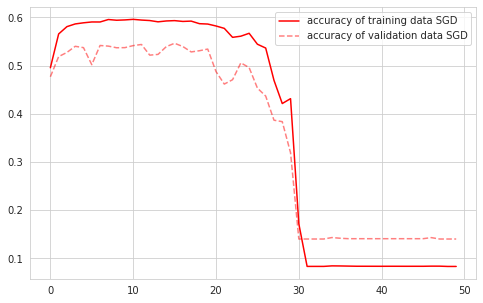

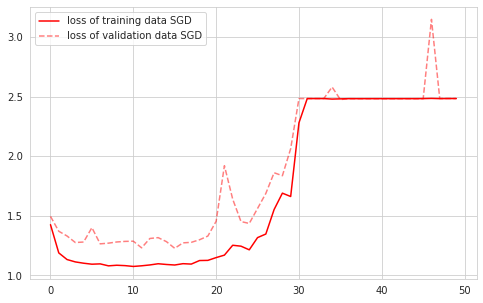

In [66]:
i=0
plt.plot(SGD_lr4[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_lr4[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_lr4[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_lr4[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

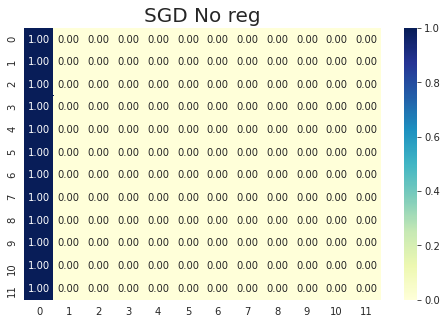

In [67]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model4.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD lr 0.05', fontsize=20)
plt.show()

# SGD Learning rate 0.008

In [68]:
opt = optimizers.SGD(lr = 0.008, momentum = 0.9, nesterov = True, decay = 1e-6)
model5 = create_model_diminuito(opt)

fit = model5.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_lr5 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 323, 64)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 323, 64)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 319, 32)           10272     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 159, 32)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 5088)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 12)               

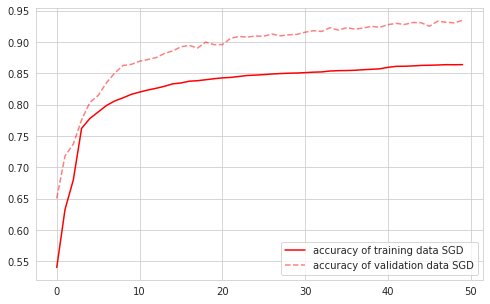

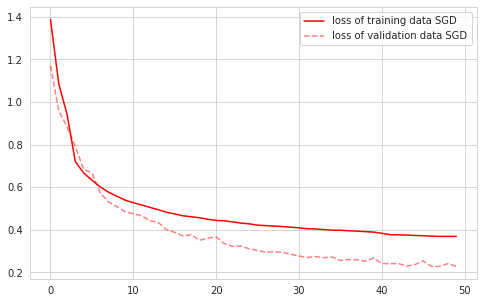

In [69]:
i=0
plt.plot(SGD_lr5[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_lr5[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_lr5[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_lr5[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

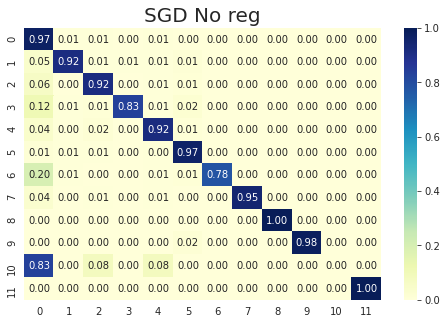

In [70]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model5.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD lr 0.008', fontsize=20)
plt.show()

# Grafici

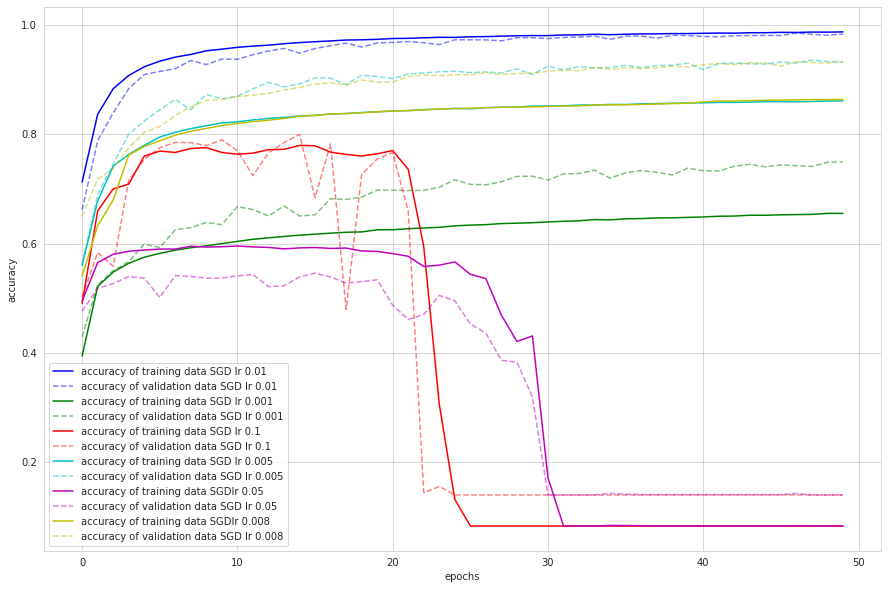

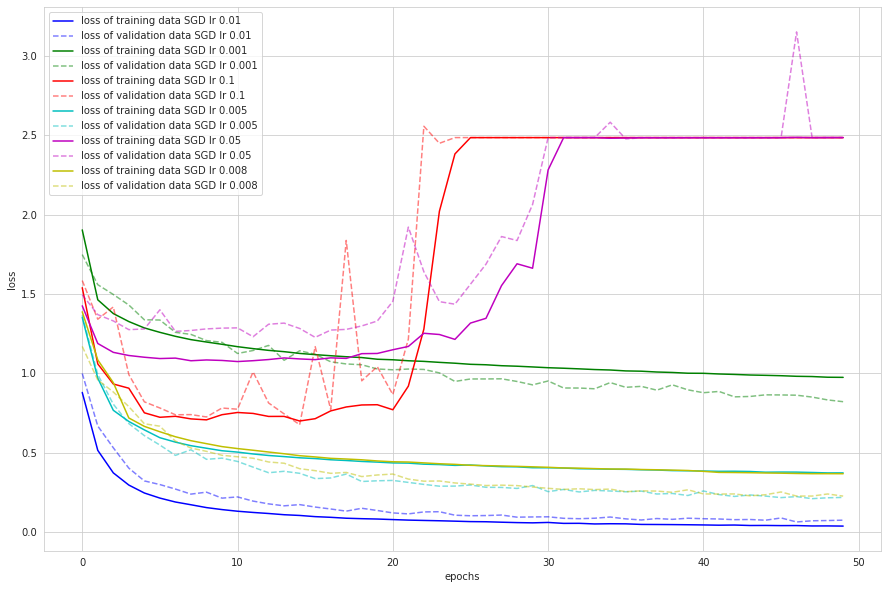

In [135]:
plt.rcParams['figure.figsize'] = [15, 10]  # Bigger images
i=0
plt.plot(SGD_lr0[i], 'b', label = 'accuracy of training data SGD lr 0.01')
plt.plot(SGD_lr0[i+1], 'b--', label = 'accuracy of validation data SGD lr 0.01', alpha=0.5)

plt.plot(SGD_lr1[i], 'g', label = 'accuracy of training data SGD lr 0.001')
plt.plot(SGD_lr1[i+1], 'g--', label = 'accuracy of validation data SGD lr 0.001', alpha=0.5)

plt.plot(SGD_lr2[i], 'r', label = 'accuracy of training data SGD lr 0.1')
plt.plot(SGD_lr2[i+1], 'r--', label = 'accuracy of validation data SGD lr 0.1', alpha=0.5)

plt.plot(SGD_lr3[i], 'c', label = 'accuracy of training data SGD lr 0.005')
plt.plot(SGD_lr3[i+1],'c--', label = 'accuracy of validation data SGD lr 0.005', alpha=0.5)

plt.plot(SGD_lr4[i], 'm', label = 'accuracy of training data SGDlr 0.05')
plt.plot(SGD_lr4[i+1], 'm--', label = 'accuracy of validation data SGD lr 0.05', alpha=0.5)

plt.plot(SGD_lr5[i], 'y', label = 'accuracy of training data SGDlr 0.008')
plt.plot(SGD_lr5[i+1], 'y--', label = 'accuracy of validation data SGD lr 0.008', alpha=0.5)
plt.legend() 
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig('accuracy_lr')
plt.show()

i=2
plt.plot(SGD_lr0[i], 'b', label = 'loss of training data SGD lr 0.01')
plt.plot(SGD_lr0[i+1], 'b--', label = 'loss of validation data SGD lr 0.01', alpha=0.5)

plt.plot(SGD_lr1[i], 'g', label = 'loss of training data SGD lr 0.001')
plt.plot(SGD_lr1[i+1], 'g--', label = 'loss of validation data SGD lr 0.001', alpha=0.5)

plt.plot(SGD_lr2[i], 'r', label = 'loss of training data SGD lr 0.1')
plt.plot(SGD_lr2[i+1], 'r--', label = 'loss of validation data SGD lr 0.1', alpha=0.5)

plt.plot(SGD_lr3[i], 'c', label = 'loss of training data SGD lr 0.005')
plt.plot(SGD_lr3[i+1], 'c--', label = 'loss of validation data SGD lr 0.005', alpha=0.5)

plt.plot(SGD_lr4[i], 'm', label = 'loss of training data SGD lr 0.05')
plt.plot(SGD_lr4[i+1], 'm--', label = 'loss of validation data SGD lr 0.05', alpha=0.5)

plt.plot(SGD_lr5[i], 'y', label = 'loss of training data SGD lr 0.008')
plt.plot(SGD_lr5[i+1], 'y--', label = 'loss of validation data SGD lr 0.008', alpha=0.5)
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss') 
plt.savefig('loss_lr.png')
plt.show()

In questi due grafici abbiamo riassunto l'accuracy e la loss delle varie reti. Si vede che la traccia blu risulta quella migliore, quella con learning rate 0.01. In particolare si nota come la rossa e la viola rispettivamente 0.1 e 0.05 non vadano a convergenza.

# Variazione layers
Si è poi variato il layer centrale di convoluzione cercando di ottenere valori di parametri attorno a 60000 per mantenerli inferiori al numero di dati. In particolare si sono ottenuti 71724, 64300, 36060, 50076

In [113]:
def create_model_diminuito1(optimizer, activation='relu'):
    model = Sequential()
    model.add(Conv1D(64, 5, strides=1, input_shape = input_shape, activation=activation))
    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, 1, strides=1, activation=activation))
    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(12, activation = activation))
    model.add(Softmax())
   
    print(model.summary())

    model.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizer, metrics = ['accuracy']) 
    
    return model

In [130]:
opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
model_l1 = create_model_diminuito1(opt)

fit = model_l1.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_l1 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_60 (MaxPooling (None, 323, 64)           0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 323, 64)           0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 323, 32)           2080      
_________________________________________________________________
max_pooling1d_61 (MaxPooling (None, 161, 32)           0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 5152)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 12)              

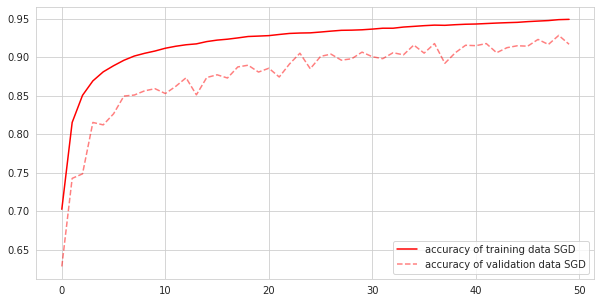

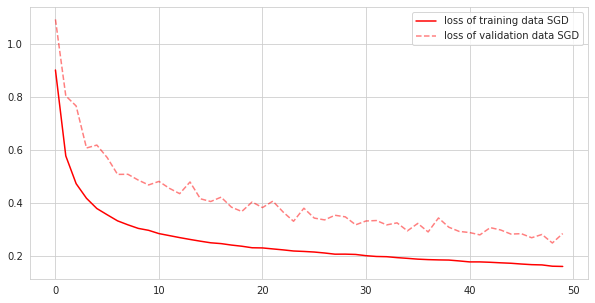

In [131]:
plt.rcParams['figure.figsize'] = [10, 5]  # Bigger images
i=0
plt.plot(SGD_l1[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_l1[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_l1[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_l1[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

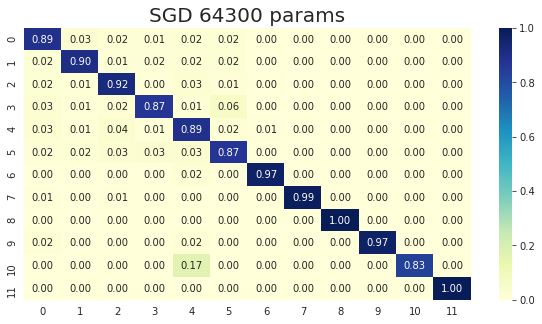

In [132]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model_l1.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD 64300 params', fontsize=20)
plt.show()

In [122]:
def create_model_diminuito2(optimizer, activation='relu'):
    model = Sequential()
    model.add(Conv1D(64, 5, strides=1, input_shape = input_shape, activation=activation))
    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(16, 20, strides=1, activation=activation))
    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(12, activation = activation))
    model.add(Softmax())

    print(model.summary())

    model.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [123]:
opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
model_l2 = create_model_diminuito2(opt)

fit = model_l2.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_l2 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_56 (Conv1D)           (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 323, 64)           0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 323, 64)           0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 304, 16)           20496     
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 152, 16)           0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 2432)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 12)              

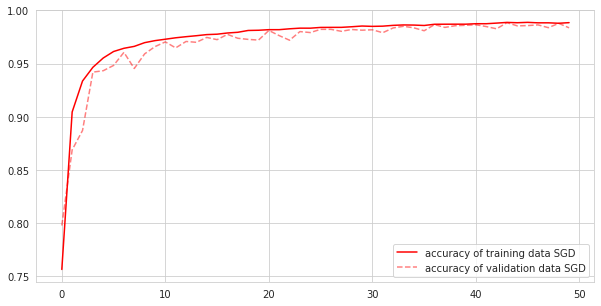

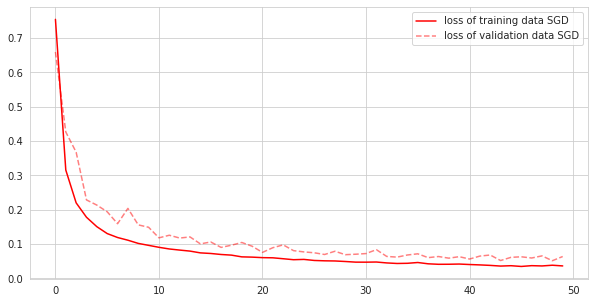

In [124]:
plt.rcParams['figure.figsize'] = [10, 5]
i=0
plt.plot(SGD_l2[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_l2[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_l2[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_l2[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

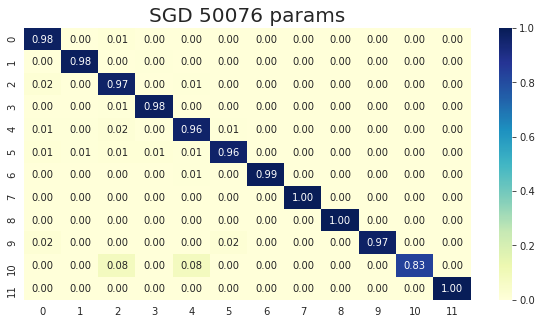

In [125]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model_l2.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD 50076 params', fontsize=20)
plt.show()

In [126]:
def create_model_diminuito3(optimizer, activation='relu'):
    model = Sequential()
    model.add(Conv1D(64, 5, strides=1, input_shape = input_shape, activation=activation))
    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(16, 5, strides=1, activation=activation))
    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(12, activation = activation))
    model.add(Softmax())
    
    print(model.summary())

    model.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [127]:
opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
model_l3 = create_model_diminuito3(opt)

fit = model_l3.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_l3 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_58 (MaxPooling (None, 323, 64)           0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 323, 64)           0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 319, 16)           5136      
_________________________________________________________________
max_pooling1d_59 (MaxPooling (None, 159, 16)           0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 2544)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 12)              

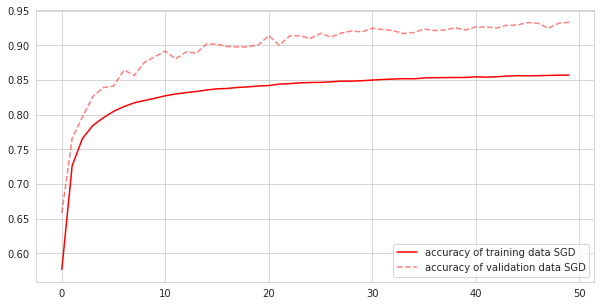

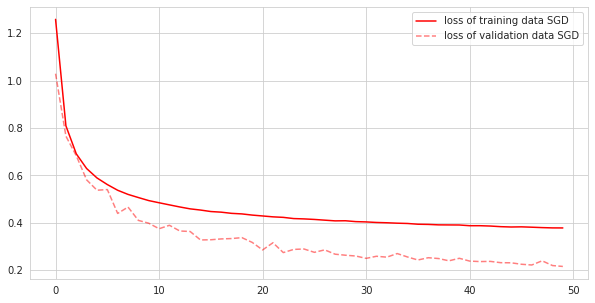

In [128]:
plt.rcParams['figure.figsize'] = [10, 5] 
i=0
plt.plot(SGD_l3[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_l3[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_l3[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_l3[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

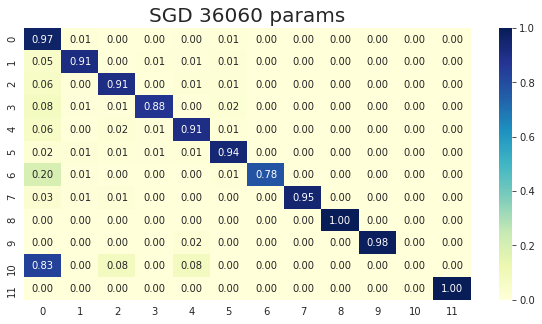

In [129]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model_l3.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD 36060 params', fontsize=20)
plt.show()

# Grafici layers

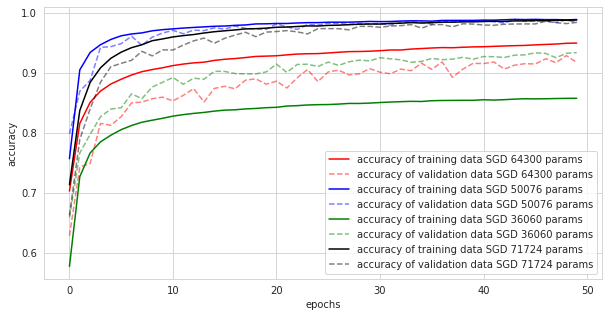

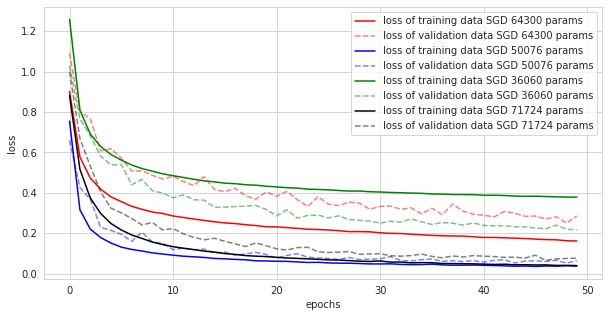

In [134]:
plt.rcParams['figure.figsize'] = [10, 5]
i=0
plt.plot(SGD_l1[i], 'r', label = 'accuracy of training data SGD 64300 params')
plt.plot(SGD_l1[i+1], 'r--', label = 'accuracy of validation data SGD 64300 params', alpha=0.5)

plt.plot(SGD_l2[i], 'b', label = 'accuracy of training data SGD 50076 params')
plt.plot(SGD_l2[i+1], 'b--', label = 'accuracy of validation data SGD 50076 params', alpha=0.5)

plt.plot(SGD_l3[i], 'g', label = 'accuracy of training data SGD 36060 params')
plt.plot(SGD_l3[i+1], 'g--', label = 'accuracy of validation data SGD 36060 params', alpha=0.5)

plt.plot(SGD_lr0[i], 'k', label = 'accuracy of training data SGD 71724 params')
plt.plot(SGD_lr0[i+1], 'k--', label = 'accuracy of validation data SGD 71724 params', alpha=0.5)
plt.legend() 
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig('accuracy_layers.png')
plt.show()

i=2
plt.plot(SGD_l1[i], 'r', label = 'loss of training data SGD 64300 params')
plt.plot(SGD_l1[i+1], 'r--', label = 'loss of validation data SGD 64300 params', alpha=0.5)

plt.plot(SGD_l2[i], 'b', label = 'loss of training data SGD 50076 params')
plt.plot(SGD_l2[i+1], 'b--', label = 'loss of validation data SGD 50076 params', alpha=0.5)

plt.plot(SGD_l3[i], 'g', label = 'loss of training data SGD 36060 params')
plt.plot(SGD_l3[i+1], 'g--', label = 'loss of validation data SGD 36060 params', alpha=0.5)

plt.plot(SGD_lr0[i], 'k', label = 'loss of training data SGD 71724 params')
plt.plot(SGD_lr0[i+1], 'k--', label = 'loss of validation data SGD 71724 params', alpha=0.5)
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('loss_layers.png')
plt.show()


In questi grafici riassuntivi si nota che la traccia nera (71724 parametri) e quella blu (50076 parametri) sono quelle che hanno dato risultati migliori anche confrontando le confusion matrix. Si è dunque deciso di mantenere il modello con 50076 parametri.